In [99]:
from __future__ import print_function

import os
import glob
import sys
import re
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D,Reshape
from keras.layers import Conv1D, MaxPooling1D, Embedding,LSTM, Dropout, Bidirectional
from keras.models import Model, load_model
import pandas as pd
import pickle
import csv
from pympler.asizeof import asizeof, flatsize
from sklearn import preprocessing
import nltk
import string
from sklearn.utils.class_weight import compute_class_weight
import keras
import random
import datetime
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
from keras.utils.vis_utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
%matplotlib inline

# <font color='blue'>Part1</font>
### Basic data preparation steps

In [72]:
salesDF = pd.read_csv("sample_data.csv")

In [3]:
#Aggregating purchases made on the same day by the same customer
salesDF=salesDF.groupby(['cust_id','order_date'],as_index=False)['units_purchased'].sum()

In [92]:
salesDF.groupby('cust_id').size().describe()

count    12489.000000
mean        25.897750
std         34.272185
min          1.000000
25%          6.000000
50%         15.000000
75%         33.000000
max        543.000000
dtype: float64

##### An average customerin our dataset has ~22 store visits

In [93]:
salesDF['units_purchased'].describe()

count    323437.000000
mean          3.601415
std           3.550222
min           0.000000
25%           1.000000
50%           3.000000
75%           4.000000
max         250.000000
Name: units_purchased, dtype: float64

##### Average number of units purchased per visit ~3-4

In [5]:
salesDF["order_date"] = pd.to_datetime(salesDF['order_date'])
idx = pd.date_range('03-15-2015', '03-30-2016')

In [7]:
#How many customers purchased less than 3 items in a visit?
#However, they might purchase 3 or more items during the week
#In this exercise, we will use the second case as our response variable
salesDF.shape, salesDF[salesDF['units_purchased'] <3].shape

((283838, 3), (119581, 3))

In [8]:
#Splitting the data frame by customers
customers = [g.reset_index(drop=True) for n, g in salesDF.groupby('cust_id')]

In [10]:
customers[0].head()

,cust_id,order_date,units_purchased
0,4005940437,2015-03-20,3
1,4005940437,2015-03-21,4
2,4005940437,2015-03-23,3
3,4005940437,2015-03-25,3
4,4005940437,2015-03-27,3


### We will look at the buying pattern of 20 random customers

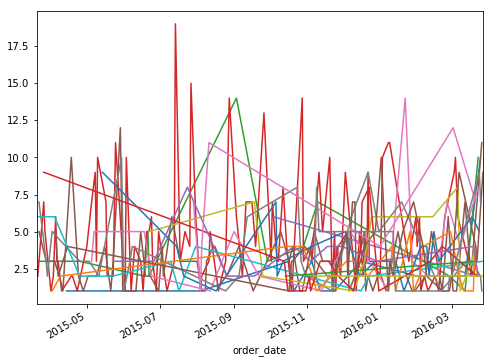

In [11]:
fig, ax = plt.subplots(figsize=(8,6))
pd.concat(random.sample(customers, 20)).groupby('cust_id')\
.plot(x='order_date',y='units_purchased',kind='line', ax=ax,legend=False);

### As seen above, it does not seem like there is trend or seasonality in the data, the data seems to be stationary with constant mean and variance (at least visually)

In [12]:
#Function to be used to calculate the predictor
def sum_less_than_three(l):
    if sum(l) <3:
        return 1
    else:
        return 0

In [13]:
#Get weekly data ending on Saturday (I have verified, this works)
weeks = [g.reset_index(drop=True)
         for n, g in salesDF.groupby(pd.Grouper(freq='W-SAT', key='order_date'))]

### The response variable is calculated for each week, for all customers that shopped that week

In [15]:
weeks_sum={}
for (i,w) in enumerate(weeks):
    weeks_sum[i]= w.groupby('cust_id')['units_purchased'].agg(lambda x:sum_less_than_three(x)).reset_index()

### The feature set (purchases in a visit) are aggegated for each customer and saved in flat files
#### <font color='indianred'>Note:</font> Please crate a folder called wp under the current directory

In [16]:
wp = pd.DataFrame(columns=idx)
for (i,c) in enumerate(customers):
    cust_id = c['cust_id'].values[0]
    c1 = c.set_index('order_date')
    c1 = c1.reindex(idx, fill_value=0)
    c1['cust_id'] = cust_id
    salesDFpivot=pd.pivot_table(c1,index ='cust_id',values='units_purchased',columns=idx).fillna(0)
    wp = pd.concat([wp,salesDFpivot])
    if i%1000 == 0:
        wp.to_csv('wp/wp_'+str(i)+'.csv',sep='|')
        wp = pd.DataFrame(columns=idx)

### The response variables are also pickled in file
#### <font color='indianred'>Note:</font> Please crate a folder called purchases under the current directory

In [17]:
with open('purchases/weeks_sum.p', 'wb') as f:
    pickle.dump(weeks_sum,f)

# <font color='blue'>Part 2</font>
### Deep Learning model building

In [3]:
BASE_DIR = './'
DATA_DIR = os.path.join(BASE_DIR, 'wp')
TARGET_DIR = os.path.join(BASE_DIR, 'purchases') 
MAX_SEQUENCE_LENGTH = 28
VALIDATION_SPLIT = 0.1
N=10

In [4]:
csvs = glob.glob(DATA_DIR + '/*.csv')

In [5]:
wDF =pd.concat([pd.read_csv(s, sep='|', header=0) for s in csvs])
wDF.columns = ['cust_id'] + wDF.columns[1:].tolist()

In [6]:
wDF[wDF['cust_id']==4005946835]

,cust_id,2015-03-15,2015-03-16,2015-03-17,2015-03-18,2015-03-19,2015-03-20,2015-03-21,2015-03-22,2015-03-23,...,2016-03-21,2016-03-22,2016-03-23,2016-03-24,2016-03-25,2016-03-26,2016-03-27,2016-03-28,2016-03-29,2016-03-30
14,4005946835,0,0,0,0,0,0,2,0,0,...,0,0,0,4,0,0,0,0,0,0


In [7]:
with open(TARGET_DIR + '/weeks_sum.p', 'rb') as f:
    targets = pickle.load(f)

In [8]:
(len(list(wDF))-1)//MAX_SEQUENCE_LENGTH -1

12

### Since the data does not have any visible trend or seasonality, most recent data for a short period of time may be suficient to build a model. We are going to use 1 month of purchase data to build our model

In [8]:
l = (len(list(wDF))-1)//MAX_SEQUENCE_LENGTH -1
sequences = []
labels = []
for i in range(l):
    s = pd.concat([wDF.iloc[:,0],wDF.iloc[:,1+i*MAX_SEQUENCE_LENGTH:1+(i+1)*MAX_SEQUENCE_LENGTH]]
                  ,axis=1)
    cust_hist = s.merge(targets[i*MAX_SEQUENCE_LENGTH//7+1],on='cust_id')
    sequences += cust_hist.iloc[:,1:-1].values.tolist()
    labels += cust_hist.iloc[:,-1].values.tolist()

In [9]:
len(sequences[-1]), len(sequences), len(labels)

(28, 40923, 40923)

In [10]:
data = pad_sequences(np.array(sequences), maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)

Shape of data tensor: (40923, 28)


In [12]:
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

### Class weights are used for the test set so that the model calculates loss and accuracy based on class weights in the test set

In [13]:
x_train = data[:-num_validation_samples]
y_train = to_categorical(labels[:-num_validation_samples])
x_val = data[-num_validation_samples:]
y_val = to_categorical(labels[-num_validation_samples:])
class_wt = compute_class_weight('balanced', np.unique(labels[-num_validation_samples:]),
                                labels[-num_validation_samples:])

In [14]:
#model = load_model(os.path.join(BASE_DIR + 'models/model_title_LSTM4.h5'))

In [15]:
print(x_train.shape, len(y_train))

(36831, 28) 36831


In [94]:
keras.backend.clear_session()
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = Reshape((MAX_SEQUENCE_LENGTH,1))(sequence_input)
x = Dropout(0.1)(x)
x = LSTM(64)(x)
x = Dropout(0.1)(x)
preds = Dense(len(np.unique(labels)), activation='sigmoid')(x)

model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


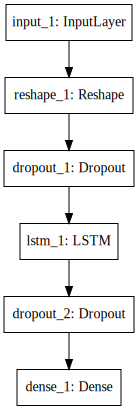

In [100]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [20]:
print('Training model.')
model.fit(x_train, y_train,
          batch_size=128,
          class_weight=class_wt,
          epochs=10,
          validation_data=(x_val, y_val))
model.save(os.path.join(BASE_DIR + 'models/model_LSTMAug2018_1.h5'))

Training model.
Train on 36831 samples, validate on 4092 samples
Epoch 1/10
36831/36831 [==============================] - 6s - loss: 0.4123 - acc: 0.8171 - val_loss: 0.2951 - val_acc: 0.8814
Epoch 2/10
36831/36831 [==============================] - 6s - loss: 0.3165 - acc: 0.8709 - val_loss: 0.2513 - val_acc: 0.9051
Epoch 3/10
36831/36831 [==============================] - 6s - loss: 0.2760 - acc: 0.8882 - val_loss: 0.2037 - val_acc: 0.9278
Epoch 4/10
36831/36831 [==============================] - 6s - loss: 0.2455 - acc: 0.8964 - val_loss: 0.2134 - val_acc: 0.9118
Epoch 5/10
36831/36831 [==============================] - 6s - loss: 0.2283 - acc: 0.9027 - val_loss: 0.1299 - val_acc: 0.9541
Epoch 6/10
36831/36831 [==============================] - 6s - loss: 0.2138 - acc: 0.9063 - val_loss: 0.1456 - val_acc: 0.9478
Epoch 7/10
36831/36831 [==============================] - 6s - loss: 0.2052 - acc: 0.9095 - val_loss: 0.1141 - val_acc: 0.9618
Epoch 8/10
36831/36831 [======================

### Let us take a sample pattern of 28 days of items purchased by a customer, and predict the probability of coming back next week, but less that 3 purchases from the model

In [33]:
ll = random.randint(1,len(data))
data[ll-1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [34]:
model.predict(data[ll-1].reshape(-1,MAX_SEQUENCE_LENGTH))

array([[0.0233695, 0.9768465]], dtype=float32)

### So there is 97% probability that the person will come back next week, but will purchase less than 3 items

# <font color='blue'>Part 3</font>
### Using tree based model

In [37]:
import xgboost as xgb
from xgboost import plot_importance,plot_tree
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

In [60]:
len(data), len(labels)

(40923, 40923)

In [61]:
dataDF = pd.DataFrame(data,columns = ['Week-minus-'+str(i)+'days' for i in range(28,0,-1)])

In [62]:
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])
x_train = dataDF[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = dataDF[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

In [63]:
sm = SMOTE(random_state=123)
x_train_res, y_train_res = sm.fit_sample(x_train, y_train)

In [64]:
x_train_res = pd.DataFrame(x_train_res, columns=x_train.columns)

In [65]:
Counter(y_train_res)

Counter({0: 24822, 1: 24822})

In [66]:
cv_params = {
     'nthread':[4],
     'objective':['binary:logistic'],
     'n_estimators':[9,11],
     'max_depth':[5,6],
     'min_child_weight':[0.5,1,2],
     'colsample_bytree':[0.1,0.2],
     'colsample_bylevel':[0.1,0.2],
     'subsample': [0.8,0.9],
     'silent': [1],
     'seed':[123]
}

cv = StratifiedKFold(n_splits=10, random_state=123)
optimized_GBM = GridSearchCV(xgb.XGBClassifier(random_state=123), 
                            cv_params, cv = cv, n_jobs=-1, scoring='roc_auc')

In [67]:
optimized_GBM.fit(x_train_res, y_train_res)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=123, shuffle=False),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=123, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'nthread': [4], 'objective': ['binary:logistic'], 'n_estimators': [9, 11], 'max_depth': [5, 6], 'min_child_weight': [0.5, 1, 2], 'colsample_bytree': [0.1, 0.2], 'colsample_bylevel': [0.1, 0.2], 'subsample': [0.8, 0.9], 'silent': [1], 'seed': [123]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [68]:
optimized_GBM.best_params_

{'colsample_bylevel': 0.1,
 'colsample_bytree': 0.2,
 'max_depth': 6,
 'min_child_weight': 1,
 'n_estimators': 9,
 'nthread': 4,
 'objective': 'binary:logistic',
 'seed': 123,
 'silent': 1,
 'subsample': 0.9}

In [69]:
y_pred = optimized_GBM.predict(x_val)
print(classification_report(y_val, y_pred))
print("Accuracy:",accuracy_score(y_val, y_pred))

             precision    recall  f1-score   support

          0       0.95      0.77      0.85      2804
          1       0.64      0.92      0.76      1288

avg / total       0.86      0.81      0.82      4092

Accuracy: 0.8140273704789834


C:\Users\rajde\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


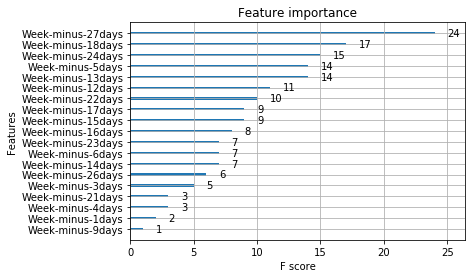

In [70]:
plot_importance(optimized_GBM.best_estimator_);

## <font color='indianred'>As seen in the graph above, the number of purchases made by a customer 27 days before the week, is the biggest predictor that he/she is going to make less than 3 purchases on that week</font>